# Otsu algorithm

Import the necessary libraries

In [3]:
import math              
import numpy as np       
from matplotlib import pyplot as plt   
from PIL import Image 
import cv2

In order to implement the algorithm, we are gonna use a dictionary to store the threshold values for each pixel intensity, and a histogram list.

In [4]:
threshold_values = {}
threshold_values_between = {}
h_list = [1]

Also, we need to load the image, convert it to grayscale and then save it as a numpy array.

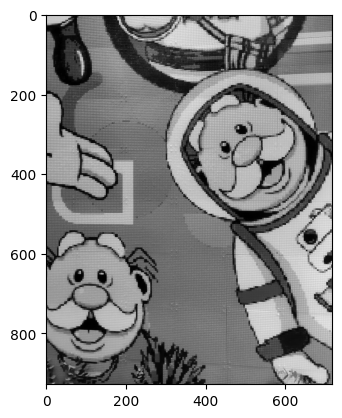

In [5]:
image=Image.open("img.jpg").convert("L")
image_numpy = np.asarray(image)
plt.imshow(image_numpy, cmap='gray')



Now, we are gonna compute the histogram of the image. Then, we are going to save it in the variable H_list-

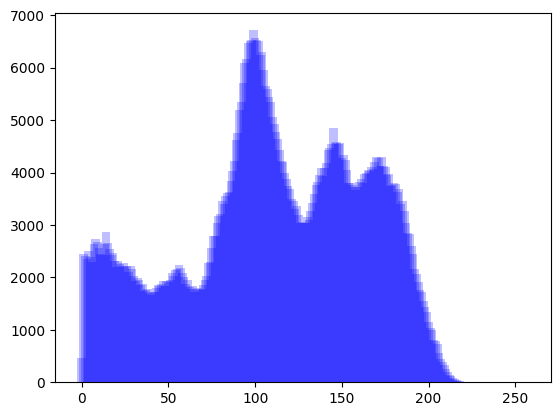

In [6]:
row, col = image_numpy.shape
    
y = np.zeros(256)
    
for i in range(0, row):
    for j in range(0, col):
        y[image_numpy[i, j]] += 1
    
# Plot the histogram
x = np.arange(0, 256)  
plt.bar(x, y, color='b', width=5, align='center', alpha=0.25)  
plt.show()  
    
h_list = y

We want to maximize the variance between the classes, and minimize the in-class variance.
A class is a set of pixels belonging to a region.



Also, to implement the method it is necessary to count pixels in the histogram

In [7]:
def countPixel(h):
    c = 0
    for i in range(0, len(h)):
        if h_list[i] > 0:
           c += h_list[i]
    return c

We need to calculate the probabilities and the number of pixels

In [8]:
cnt = countPixel(h_list)
probabilities = h_list/cnt

In order to implement the Otsu's Method, we need to define some functions to calculate the class probabilities (q(t)), the class mean (u(t))  and the individual class variance.

In [9]:
def weight_pix(s, e):
    w = 0
    
    for i in range(s, e):
        w += h_list[i]
    return w

def mean_pix(s, e):
    m = 0
    w = weight_pix(s, e)

    for i in range(s, e):
        m += h_list[i] * i
    return m / float(w)

def variance_pix(s, e):
    v = 0
    m = mean_pix(s, e)
    w = weight_pix(s, e)

    for i in range(s, e):
        v += ((i - m) ** 2) * h_list[i]/w
    return v

Finally, we are going to calculate the variance, weight and mean for the background and foreground class.

In [10]:


# Loop through each possible threshold value from 1 to 255 (as h has 256 bins, one for each intensity level)
for i in range(1, len(h_list)):

    # Compute the variance, probabilities, and mean for the "background" class
    v_back = variance_pix(0, i)
    w_back = weight_pix(0, i) / float(cnt)
    m_back = mean_pix(0, i)
    
    # Compute the variance, probabilities, and mean for the "foreground" class 
    v_fore = variance_pix(i, len(h_list))
    w_fore = weight_pix(i, len(h_list)) / float(cnt)
    m_fore = mean_pix(i, len(h_list))
   
    # Compute within-class variance (within_variance) 
    within_variance = w_back * (v_back) + w_fore * (v_fore)
    
    # Compute between-class variance (between_variance) 
    between_variance = w_back * w_fore * (m_back - m_fore)**2
        
          
    if not math.isnan(within_variance):
        threshold_values[i] = within_variance

    if not math.isnan(between_variance):
        threshold_values_between[i] = between_variance

/var/folders/h4/v6kv36fs44lg2yrrlf2z2jyr0000gn/T/ipykernel_22573/773017151.py:14: RuntimeWarning: invalid value encountered in scalar divide
  return m / float(w)


Then, we are going to select the threshold which minimize the within classes variance.

In [11]:
min_within_variance = min(threshold_values.values())
optimal_threshold = [k for k, v in threshold_values.items() if v == min_within_variance]
print('optimal threshold', optimal_threshold[0])
optim_threshold = optimal_threshold[0]



optimal threshold 110


Now, let´s calculate the optimal threshold that maximizes the between class variance:


In [12]:
max_within_variance_between = max(threshold_values_between.values())
optimal_threshold = [k for k, v in threshold_values_between.items() if v == max_within_variance_between]
print('optimal threshold', optimal_threshold[0])
optim_threshold_between = optimal_threshold[0]

optimal threshold 110


Finally, we are going to restore the picture using the calculated optimal threshold

In [13]:
row, col = image_numpy.shape 
y = np.zeros((row, col))
for i in range(0, row):
    for j in range(0, col):
        if image_numpy[i, j] >= optim_threshold:
            y[i, j] = 255
        else:
            y[i, j] = 0
result = y

We plot the result, and save the image for the future activities.

True

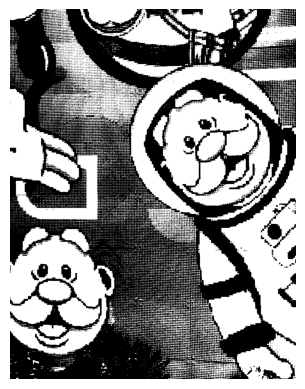

In [14]:
plt.imshow(result, cmap='gray')
plt.axis('off')
result_255 = result.astype(np.uint8)

# Step 2: Save the image
cv2.imwrite("result.png", result_255)
cv2.imwrite("otsu.png", 255 * result)

## Extract the object boundaries using Laplacian (Zero-crossing)

In [15]:
import cv2 as cv
from scipy.signal import convolve2d

Compute gradient using sobel operator

In [16]:
gradHorizontal = cv.Sobel(result, cv.CV_64F, 1, 0, ksize=5)
gradVertical = cv.Sobel(result, cv.CV_64F, 0, 1, ksize=5)
gradBoth = cv.Sobel(result, cv.CV_64F, 1, 1, ksize=5)

gradEdgesDetected = np.abs(gradHorizontal) + np.abs(gradVertical)

We defined the kernel and threshold

In [17]:
kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]]) / 4.0
threshold = 2 * np.sqrt(np.var(gradEdgesDetected.flatten()))

laplacian = convolve2d(result, kernel, mode="same")

we saved the image to work with it in the point 5

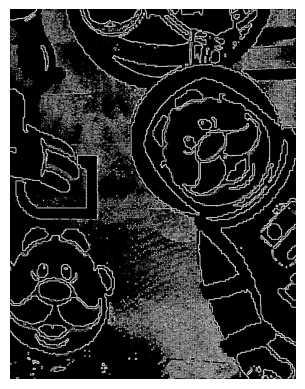

<Figure size 640x480 with 0 Axes>

In [18]:
zeroCrossingImg = np.abs(laplacian) < 0.05 * threshold
zeroCrossingAtSobel = np.multiply(zeroCrossingImg, gradEdgesDetected > threshold)

plt.imshow(zeroCrossingAtSobel, cmap="gray")
#plt.title("Zero-Crossing Points Edge Detection")
plt.axis('off')
plt.show()
plt.savefig("otsu_boundaries.png")

Then we plot the three images.

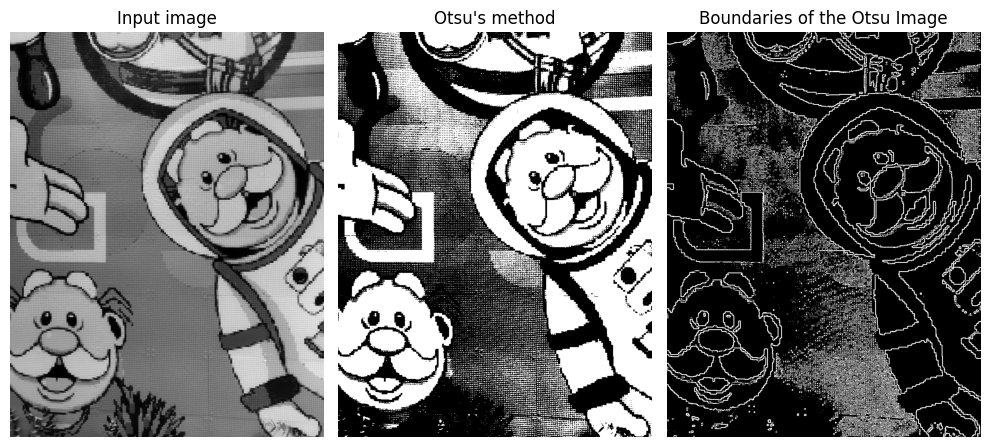

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[1].imshow(result, cmap='gray')
axs[1].set_title("Otsu's method")
axs[1].axis('off')  

axs[0].imshow(image_numpy, cmap='gray')
axs[0].set_title("Input image")
axs[0].axis('off')  

axs[2].imshow(zeroCrossingAtSobel, cmap='gray')
axs[2].set_title("Boundaries of the Otsu Image")
axs[2].axis('off')  

# Show the figure
plt.tight_layout()
plt.show()

# 5. Distance Map

Unique pixel values in the image: [  0. 255.]
Image data type: float64
Image data type: uint8
Unique pixel values in the image: [  0. 255.]


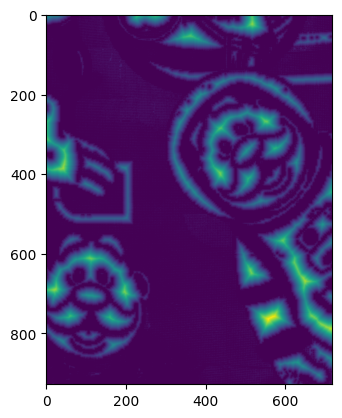

In [20]:

from __future__ import print_function
import cv2 as cv
import numpy as np
import argparse
import random as rng

unique_values = np.unique(result)

print(f"Unique pixel values in the image: {unique_values}")

print(f"Image data type: {result.dtype}")

result=result.astype('uint8')

print(f"Image data type: {result.dtype}")
print(f"Unique pixel values in the image: {unique_values}")


dist = cv.distanceTransform(result, cv.DIST_L2, 3)

cv.normalize(dist, dist, 0, 1.0, cv.NORM_MINMAX)
plt.imshow(dist)


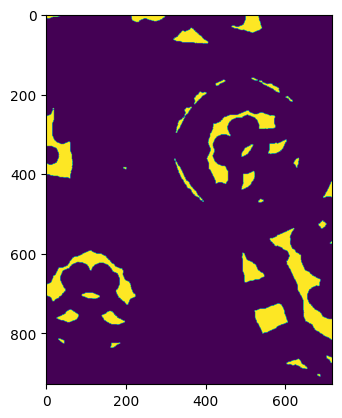

In [21]:
# Threshold to obtain the peaks
# This will be the markers for the foreground objects
_, dist = cv.threshold(dist, 0.4, 1.0, cv.THRESH_BINARY)
# Dilate a bit the dist image
kernel1 = np.ones((3,3), dtype=np.uint8)
dist = cv.dilate(dist, kernel1)
plt.imshow(dist)

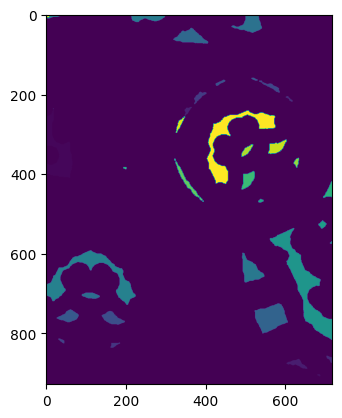

In [22]:
# Create the CV_8U version of the distance image
# It is needed for findContours()
dist_8u = dist.astype('uint8')
# Find total markers
contours, _ = cv.findContours(dist_8u, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
# Create the marker image for the watershed algorithm
markers = np.zeros(dist.shape, dtype=np.int32)
# Draw the foreground markers
for i in range(len(contours)):
    cv.drawContours(markers, contours, i, (i+1), -1)
# Draw the background marker
cv.circle(markers, (5,5), 3, (255,255,255), -1)
markers_8u = (markers * 10).astype('uint8')
plt.imshow(markers_8u)

# 6 Skeleton

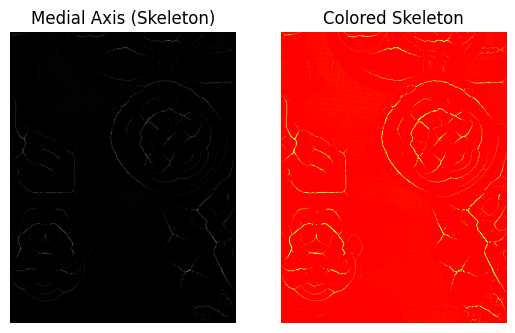

In [26]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import binary_opening, binary_erosion, generate_binary_structure

binary_img = result

# Step 3: Create an empty skeleton
skel = np.zeros_like(binary_img, dtype=np.float64)

# Get a cross-shaped structuring element
element = generate_binary_structure(2, 1)

# Step 4: Repeat skeletonization process
counter = 0
while np.any(binary_img):
    counter += 1
    
    # Step 5: Perform morphological opening (erosion followed by dilation)
    open_img = binary_opening(binary_img, structure=element).astype(np.uint8) * 255

    # Step 6: Subtract the opened image from the original
    temp = counter * ((binary_img - open_img) / 255).astype(np.float64)
    
    # Step 7: Erode the image
    eroded_img = binary_erosion(binary_img, structure=element).astype(np.uint8) * 255
    
    # Add the result to the skeleton
    skel += temp  
    
    # Update the image for the next iteration
    binary_img = eroded_img.copy()

# Normalize the skeleton to display it properly
skel = (skel - skel.min()) / (skel.max() - skel.min()) * 255
skel = skel.astype(np.uint8)

# Display the results
plt.subplot(1, 2, 1)
plt.imshow(skel, cmap='gray')
plt.title('Medial Axis (Skeleton)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(skel, cmap='hsv')
plt.title('Colored Skeleton')
plt.axis('off')

plt.show()

